## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('0948b6427e46bb1bc7fa60b52df96ab0080b9d4ff80209a5fee99277')
debug = False
from datetime import datetime 
import tensorflow as tf
pro = ts.pro_api()

In [2]:
# !pip install openpyxl

## 生成Alpha因子的基础函数

In [3]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
        return alpha_dict
        

## 生成训练集

In [5]:
import pandas as pd
price_PD_total = pd.read_csv('./data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = pro.stock_basic()
all_stock = all_stock[['ts_code','name','market']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount']]



In [6]:
indus = pd.read_csv('./data/a_stock_industry.csv',encoding='gbk')
indus = indus[['windcode','申万行业L1','申万行业L2','申万行业L3']]
indus.columns = ['ts_code','indus1','indus2','indus3']
indus.head()

,ts_code,indus1,indus2,indus3
0,000001.SZ,银行,银行Ⅱ,银行Ⅲ
1,000002.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ
2,000004.SZ,计算机,计算机应用,IT服务
3,000005.SZ,公用事业,环保工程及服务Ⅱ,环保工程及服务Ⅲ
4,000006.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ


In [7]:
##拼接行业，只保留主板、中小板、创业板，去除ST股票
price_PD_total = pd.merge(price_PD_total,indus,how='left',on='ts_code')
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)
price_PD_total.head()

,ts_code,name,market,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,indus1,indus2,indus3
0,000001.SZ,平安银行,主板,20150105,10.1514,10.3355,9.9038,10.1704,10.0562,0.1142,1.1356,2860436.43,4.565388e+06,银行,银行Ⅱ,银行Ⅲ
1,000001.SZ,平安银行,主板,20150106,10.0625,10.4053,9.8720,10.0181,10.1704,-0.1523,-1.4975,2166421.40,3.453446e+06,银行,银行Ⅱ,银行Ⅲ
2,000001.SZ,平安银行,主板,20150107,9.8784,10.0498,9.7133,9.8276,10.0181,-0.1905,-1.9016,1700120.67,2.634796e+06,银行,银行Ⅱ,银行Ⅲ
3,000001.SZ,平安银行,主板,20150108,9.8403,9.8847,9.4594,9.4975,9.8276,-0.3301,-3.3589,1407714.21,2.128003e+06,银行,银行Ⅱ,银行Ⅲ
4,000001.SZ,平安银行,主板,20150109,9.4594,10.0752,9.3388,9.5737,9.4975,0.0762,0.8023,2508500.23,3.835378e+06,银行,银行Ⅱ,银行Ⅲ


In [8]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [9]:
#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [10]:
price_PD_wfq = pd.read_csv('./data/price_PD_2015至今_未复权.csv')
price_PD_wfq.trade_date = price_PD_wfq.trade_date.astype('str')
price_PD_wfq = price_PD_wfq.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
price_PD_wfq['vwap'] = price_PD_wfq.amount/price_PD_wfq.vol
price_PD_wfq = price_PD_wfq[price_PD_wfq.ts_code.isin(price_PD_total.ts_code.unique())]
price_PD_wfq.tail()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,vwap
6220326,605599.SH,20220909,10.09,10.22,9.22,10.02,10.22,-0.20,-1.9569,58236.31,57322.643,0.984311
6220327,605599.SH,20220913,9.79,10.08,9.79,9.98,10.02,-0.04,-0.3992,31553.39,31488.568,0.997946
6220328,605599.SH,20220914,9.90,9.92,9.77,9.85,9.98,-0.13,-1.3026,18402.20,18093.121,0.983204
6220329,605599.SH,20220915,9.89,9.89,9.61,9.69,9.85,-0.16,-1.6244,14409.77,14020.617,0.972994
6220330,605599.SH,20220916,9.64,9.70,9.38,9.41,9.69,-0.28,-2.8896,14882.43,14157.309,0.951277


In [11]:
daily_info = {}
daily_info['open'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'open')
daily_info['close'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'close')
daily_info['high']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'high')
daily_info['low']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'low')
daily_info['amount']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'amount')
daily_info['volume']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'vol')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 



In [12]:
del price_PD_wfq

In [13]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [14]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████| 25/25 [02:56<00:00,  7.06s/it]


In [15]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [16]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'indus1',
       'indus2', 'indus3', 'open_up', 'ret1', 'ret2', 'ret'],
      dtype='object')

In [17]:
del price_PD_total

In [18]:
train = data.copy()
train = train[train.trade_date < '20200401']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import KFold,GroupKFold,train_test_split

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

enumsplit = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind[int(0.025*len(trn_ind)):int(0.975*len(trn_ind))], val_ind])   ##避免泄露
    enumsplit.append([trn_ind, val_ind])  ##数据存在一点点泄露
enumsplit

[[array([      0,       1,       2, ..., 3625332, 3625333, 3625334]),
  array([     12,      13,      19, ..., 3625324, 3625327, 3625330])],
 [array([      3,       4,       6, ..., 3625331, 3625332, 3625333]),
  array([      0,       1,       2, ..., 3625316, 3625328, 3625334])],
 [array([      0,       1,       2, ..., 3625331, 3625333, 3625334]),
  array([      3,      18,      23, ..., 3625326, 3625329, 3625332])],
 [array([      0,       1,       2, ..., 3625331, 3625332, 3625334]),
  array([      6,      10,      14, ..., 3625322, 3625325, 3625333])],
 [array([      0,       1,       2, ..., 3625332, 3625333, 3625334]),
  array([      4,       8,      15, ..., 3625310, 3625313, 3625331])]]

In [19]:
train.columns

Index(['ts_code', 'trade_date', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'name', 'ret1', 'ret2', 'ret',
       'open_up', 'ret_rank'],
      dtype='object')

In [20]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005']


In [21]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    


In [22]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)


def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    num_input = keras.Input(shape=(len(features),), name='num_data')

    out = num_input
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = num_input,
    outputs = out,
    )
    model.compile(
        optimizer=tf.optimizers.Adam(1e-3),
        loss='mse',
        #loss=correlationLoss,
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    return model


In [23]:
model = base_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_data (InputLayer)        [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3328      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
prediction (Dense)           (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


## 模型训练

In [24]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())


In [25]:
# from sklearn.preprocessing import QuantileTransformer

# train_nn=train[features].copy()
# test_nn=test[features].copy()
# qt_train = []
# for col in features:
#     qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
#     train_nn[col] = qt.fit_transform(train_nn[[col]])
#     test_nn[col] = qt.transform(test_nn[[col]])
#     qt_train.append(qt)

In [26]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

In [28]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']
# y = train['ret']

oof_predictions = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in enumerate(enumsplit):
    print(f'Training fold {fold + 1}')
    x_train, x_val = train.iloc[trn_ind][features], train.iloc[val_ind][features]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    
    model = base_model()

    model.fit(x_train, 
              y_train,               
              batch_size=2048,
              epochs=1000,
              validation_data=(x_val, y_val),
              callbacks=[es, plateau],
              validation_batch_size=len(y_val),
              shuffle=True,
              verbose = 1)

    
    modellist.append(model)
    oof_predictions[val_ind] = model.predict(x_val).reshape(1,-1)[0]
    
    print(f'fold RMSPE is {mean_squared_error(y_val, oof_predictions[val_ind])**0.5}')
    corrr_score = np.corrcoef([y_val, oof_predictions[val_ind]])[0,1]
    print(f'fold CORR is {corrr_score}')

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f'Our out of folds RMSPE is {rmspe_score}')
corrr_score = np.corrcoef([y, oof_predictions])[0,1]
print(f'Our out of folds CORR is {corrr_score}')

Training fold 1
Epoch 1/1000
1417/1417 [==============================] - 7s 5ms/step - loss: 5820912640.0000 - root_mean_squared_error: 76294.9062 - val_loss: 156442992.0000 - val_root_mean_squared_error: 12507.7178
Epoch 2/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 142087024.0000 - root_mean_squared_error: 11920.0264 - val_loss: 32304546.0000 - val_root_mean_squared_error: 5683.7090
Epoch 3/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 156202912.0000 - root_mean_squared_error: 12498.1162 - val_loss: 54109428.0000 - val_root_mean_squared_error: 7355.9111
Epoch 4/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 80113528.0000 - root_mean_squared_error: 8950.6162 - val_loss: 71379032.0000 - val_root_mean_squared_error: 8448.6113
Epoch 5/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 10658332.0000 - root_mean_squared_error: 3264.7102 - val_loss: 3727519.7500 - val_root_mean_squared_error: 1930.6

Epoch 46/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0834 - root_mean_squared_error: 0.2887 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2885
Epoch 47/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2885
Epoch 48/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2885
Epoch 49/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2885
Epoch 50/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2885
Epoch 51/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.

Epoch 36/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2887
Epoch 37/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2887
Epoch 38/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2887
Epoch 39/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2887
Epoch 40/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2887 - val_loss: 0.0833 - val_root_mean_squared_error: 0.2886
Epoch 41/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.

1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2888
Epoch 73/1000
1417/1417 [==============================] - 6s 5ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2888
Epoch 74/1000
1417/1417 [==============================] - 6s 5ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2888
Epoch 75/1000
1417/1417 [==============================] - 6s 5ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2888
Epoch 76/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2888
Epoch 77/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_los

fold RMSPE is 0.288792271051837
fold CORR is 0.013198164852546105
Training fold 5
Epoch 1/1000
1417/1417 [==============================] - 7s 5ms/step - loss: 5129201664.0000 - root_mean_squared_error: 71618.4453 - val_loss: 2267930880.0000 - val_root_mean_squared_error: 47622.7969
Epoch 2/1000
1417/1417 [==============================] - 6s 5ms/step - loss: 534533184.0000 - root_mean_squared_error: 23119.9746 - val_loss: 15987985408.0000 - val_root_mean_squared_error: 126443.6094
Epoch 3/1000
1417/1417 [==============================] - 6s 5ms/step - loss: 280201152.0000 - root_mean_squared_error: 16739.2109 - val_loss: 13210919.0000 - val_root_mean_squared_error: 3634.6829
Epoch 4/1000
1417/1417 [==============================] - 6s 4ms/step - loss: 353448480.0000 - root_mean_squared_error: 18800.2246 - val_loss: 26927234.0000 - val_root_mean_squared_error: 5189.1460
Epoch 5/1000
1417/1417 [==============================] - 7s 5ms/step - loss: 62626448.0000 - root_mean_squared_error

## 模型预测和收益pnl

In [29]:
num = 30
test = data.copy()
test = test[(test.open_up<1.05)&(test.open_up>0.95)]  ##不考虑高开或者低开过多的股票
test = test[test.trade_date > '20200401']

test.replace([np.inf, -np.inf], np.nan,inplace=True)
test[features] = test[features].fillna(train[features].mean())





In [ ]:

pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test[features]).reshape(1,-1)[0]
test['pred'] = pred
date_calc = sorted(test.trade_date.unique())


In [ ]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0015)
(ret_pd1.loc['20200401':'20230101',] ).cumsum().plot(rot=45, title = '2020-2022 year')


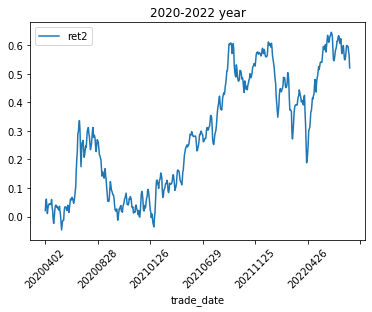

In [53]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0015)
(ret_pd1.loc['20200401':'20230101',] ).cumsum().plot(rot=45, title = '2020-2022 year')


In [54]:
# ## 考虑t收盘买 t+1收盘卖的收益情况
# tmp = test.copy()
# tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
# ret_pd2 = pd.DataFrame(tmp.groupby('trade_date').ret1.mean() - 1.0015)
# (ret_pd2.loc['20200401':'20220501',] ).cumsum().plot(rot=45, title = '2020-2022 year')


## 计算收益相关评价指标

In [55]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end

def cal_sell_turnover(tmp):
    stock = pd.DataFrame(tmp.groupby('trade_date').apply(lambda x: set(x.ts_code))).rename(columns={0:'stock_list'})
    stock['stock_list_shift1'] = stock.stock_list.shift(1)
    stock = stock.dropna()
    freq = []
    for i in range(len(stock)):
        freq.append(1 - len(stock.iloc[i]['stock_list'] & stock.iloc[i]['stock_list_shift1'])/len(stock.iloc[i]['stock_list']))
    stock['freq'] = freq
    return stock['freq'].mean()

def max_dd_month(ret_PD):
    ret2_month = ret_PD.reset_index()
    ret2_month['month'] = [str(xx)[:6] for xx in ret2_month['trade_date']]
    ret2_month = ret2_month.groupby('month')['ret'].sum()
    ret2_month = ret2_month.sort_values()
    return [ret2_month.head(1).values[0],ret2_month.head(1).index[0],\
            (ret2_month>0).sum()/len(ret2_month),ret2_month[ret2_month>=0].mean(),\
            ret2_month[ret2_month<0].mean()]

def calc_pfmc(ret_PD):
    performance = []
    ret_PD.columns = ['ret']
    returnlist = ret_PD['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)
    month_pfmc = max_dd_month(ret_PD)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()
    
    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]

    turnover = cal_sell_turnover(tmp)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,turnover,stock_pct]+month_pfmc)
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','turnover','stock_num','mdd_month','mdd_month_No',\
                    'month_winratio','month_win_ret','month_lose_ret'])

    return performance

In [56]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,turnover,stock_num,mdd_month,mdd_month_No,month_winratio,month_win_ret,month_lose_ret
0,LGB,0.225868,0.769929,0.01848,0.531732,0.643872,29.897084,-0.222064,202201,0.533333,0.09296,-0.069043


In [57]:
## 看某天的股票持仓
tmp[tmp.trade_date=='20220908'][['ts_code','name','trade_date','pred','ret','ret1','ret2']]

,ts_code,name,trade_date,pred,ret,ret1,ret2
17310,000002.SZ,万科A,20220908,0.008995,1.039451,1.032423,1.039451
17311,600184.SH,光电股份,20220908,0.008995,1.000771,0.993050,1.000771
17312,600227.SH,圣济堂,20220908,0.008995,1.020896,1.000000,1.020896
17313,600216.SH,浙江医药,20220908,0.008995,1.002514,0.998746,1.002514
17314,600207.SH,安彩高科,20220908,0.008995,0.961487,0.977454,0.961487
17315,600206.SH,有研新材,20220908,0.008995,0.997297,0.996628,0.997297
17316,600200.SH,江苏吴中,20220908,0.008995,0.986207,1.010989,0.986207
17317,600199.SH,金种子酒,20220908,0.008995,0.994418,0.998798,0.994418
17318,600197.SH,伊力特,20220908,0.008995,1.015321,1.012831,1.015321
17319,600196.SH,复星医药,20220908,0.008995,1.012048,1.030624,1.012048


In [58]:
## 计算沪深300的收益
df300 = pro.index_daily(ts_code='000300.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])
df300 = df300[['trade_date','pct_chg']].set_index('trade_date').sort_index()
df300

,pct_chg
trade_date,
20200402,1.6178
20200403,-0.5707
20200407,2.2838
20200408,-0.4654
20200409,0.3298
...,...
20220909,1.3895
20220913,0.4233
20220914,-1.1130


In [59]:
ret_pd_concat = pd.merge(ret_pd1,df300/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','df300']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['df300']
ret_pd_concat

,ret,df300,diff
trade_date,,,
20200402,0.020450,0.016178,0.004272
20200403,0.030767,-0.005707,0.036474
20200407,0.009811,0.022838,-0.013027
20200408,-0.022327,-0.004654,-0.017673
20200409,-0.028373,0.003298,-0.031671
...,...,...,...
20220909,-0.018234,0.013895,-0.032129
20220913,-0.011104,0.004233,-0.015337
20220914,-0.045628,-0.011130,-0.034498


In [60]:
ret_pd_concat.corr()

,ret,df300,diff
ret,1.000000,0.098474,0.814343
df300,0.098474,1.000000,-0.497372
diff,0.814343,-0.497372,1.000000


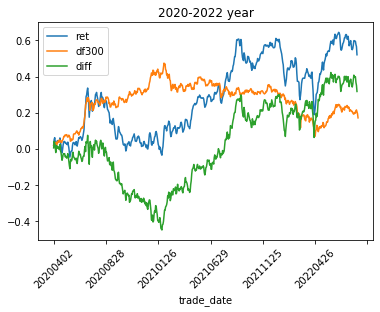

In [61]:
(ret_pd_concat[['ret','df300','diff']].cumsum()).plot(rot=45, title = '2020-2022 year')


## 计算oof的收益情况和PNL；实际参考意义不大，因为模型会过拟合训练集

,group_name,return,sharpe,std,winratio,turnover,stock_num,mdd_month,mdd_month_No,month_winratio,month_win_ret,month_lose_ret
0,LGB,0.387158,0.773621,0.031525,0.540752,0.97919,29.976507,-0.608846,201506,0.52381,0.164487,-0.11559


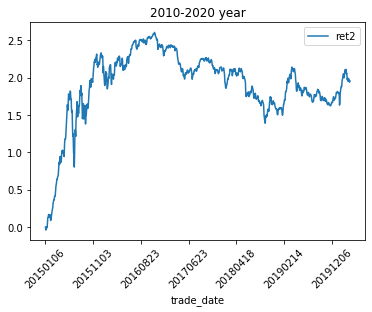

In [62]:

train['pred'] = oof_predictions

date_calc = sorted(train.trade_date.unique())
num = 30
tmp = train.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]

tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0015)
(ret_pd.loc['20100101':'20200401',] ).cumsum().plot(rot=45, title = '2010-2020 year')

calc_pfmc(ret_pd)

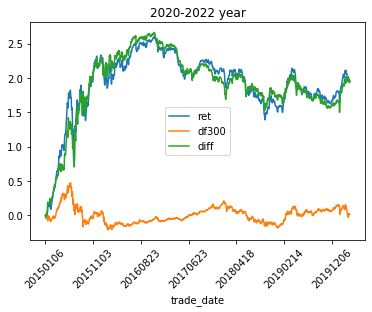

In [63]:
df300 = pro.index_daily(ts_code='000300.SH', start_date=ret_pd.index[0], end_date=ret_pd.index[-1])
df300 = df300[['trade_date','close']].set_index('trade_date').sort_index()
df300 = df300/df300.head(1).values
ret_pd_concat = pd.merge(ret_pd.cumsum(),df300-1,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','df300']
ret_pd_concat['diff'] = ret_pd_concat[['ret']]-ret_pd_concat[['df300']].values
(ret_pd_concat[['ret','df300','diff']]).plot(rot=45, title = '2020-2022 year')


In [64]:
sss = ret_pd_concat[['ret']]- ret_pd_concat[['df300']].values
calc_pfmc(sss.diff())


,group_name,return,sharpe,std,winratio,turnover,stock_num,mdd_month,mdd_month_No,month_winratio,month_win_ret,month_lose_ret
0,LGB,0.385525,0.665104,0.036514,0.511755,0.97919,29.976507,-0.507823,201506,0.492063,0.159118,-0.09319
